In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import math
from sklearn.preprocessing import StandardScaler, RobustScaler, MaxAbsScaler, QuantileTransformer
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from imblearn.over_sampling import SMOTE
import scipy.stats as stats
from sklearn.decomposition import PCA
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns

# Import csv

In [2]:
df = pd.read_csv("../dataset/dyspepsia_dataset.csv")
print(df.shape)
df.head(10)

(100, 71)


,No,Height,Weight,BMI,muscle_mass,body_fat_mass,body_fat_percentage,age,dyspepsia_vas_score,Rome_4_criteria_PDS,...,HRV_pNN50,HRV_Prc20NN,HRV_Prc80NN,HRV_RMSSD,HRV_SDNN,HRV_SDRMSSD,HRV_SDSD,HRV_TINN,diagnosis,diagnosis_type
0,5,150.1,46.7,20.7,16.9,14.6,31.3,58,65,2,...,0.000000,726.0,764.0,17.464430,23.677708,1.355768,17.517420,117.1875,1,1
1,7,159.5,49.4,19.4,19.1,13.2,26.7,58,68,2,...,0.800000,933.8,972.2,20.548330,43.330520,2.108712,20.631677,195.3125,1,1
2,10,159.3,58.4,23.0,21.1,19.4,33.2,49,61,1,...,0.000000,740.0,757.0,7.599967,9.792497,1.288492,7.623868,39.0625,1,1
3,12,160.8,60.0,23.2,21.3,20.9,34.8,53,64,2,...,0.000000,870.0,907.0,18.781490,20.609342,1.097322,18.846501,93.7500,1,1
4,14,153.3,57.4,24.4,20.3,19.4,33.9,62,85,2,...,0.000000,676.0,690.4,5.430592,8.667729,1.596093,5.444862,39.0625,1,1
5,16,158.7,58.8,23.3,20.5,20.9,35.6,59,68,1,...,25.139665,635.6,686.2,140.275952,83.995317,0.598786,140.671312,257.8125,1,1
6,19,154.8,45.4,18.9,17.1,12.9,28.4,44,58,1,...,1.418440,820.0,861.0,17.787435,28.577503,1.606612,17.850888,132.8125,1,1
7,21,167.5,59.7,21.3,23.8,15.5,25.9,45,81,1,...,0.675676,790.4,825.0,22.055588,23.941319,1.085499,22.130841,132.8125,1,1
8,24,169.2,82.5,28.8,31.3,26.0,31.5,48,55,1,...,0.675676,784.4,822.0,16.980181,23.345026,1.374840,17.038227,125.0000,1,1
9,34,166.6,70.2,25.3,25.4,23.8,33.9,54,57,2,...,0.621118,712.0,766.0,10.053295,28.814210,2.866146,10.084702,85.9375,1,1


# 사전에 엑셀에서 작업했거나 필요없는 컬럼 제거

In [3]:
df.drop(columns=['No'], inplace=True)
df.drop(columns=['Nepean_Dyspepsia_Frequency', 'Nepean_Dyspepsia_Intensity', 'Nepean_Dyspepsia_Interference'], inplace=True)

# 최종변증의 Type 분포 시각화

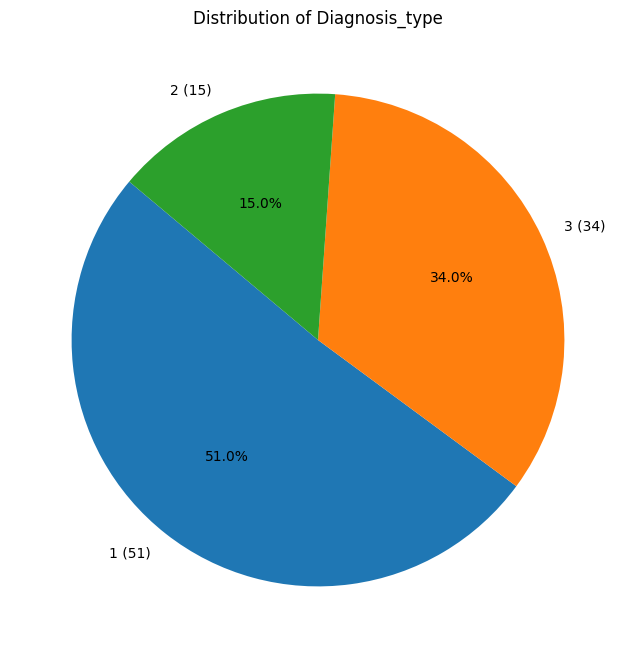

In [19]:
diagnosis_distribution = df['diagnosis_type'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(diagnosis_distribution, 
        labels=[f"{idx} ({val})" for idx, val in zip(diagnosis_distribution.index, diagnosis_distribution.values)], 
        autopct='%1.1f%%', 
        startangle=140)
plt.title("Distribution of Diagnosis_type")
plt.show()

# continuous형 변수에 대한 분포 체크

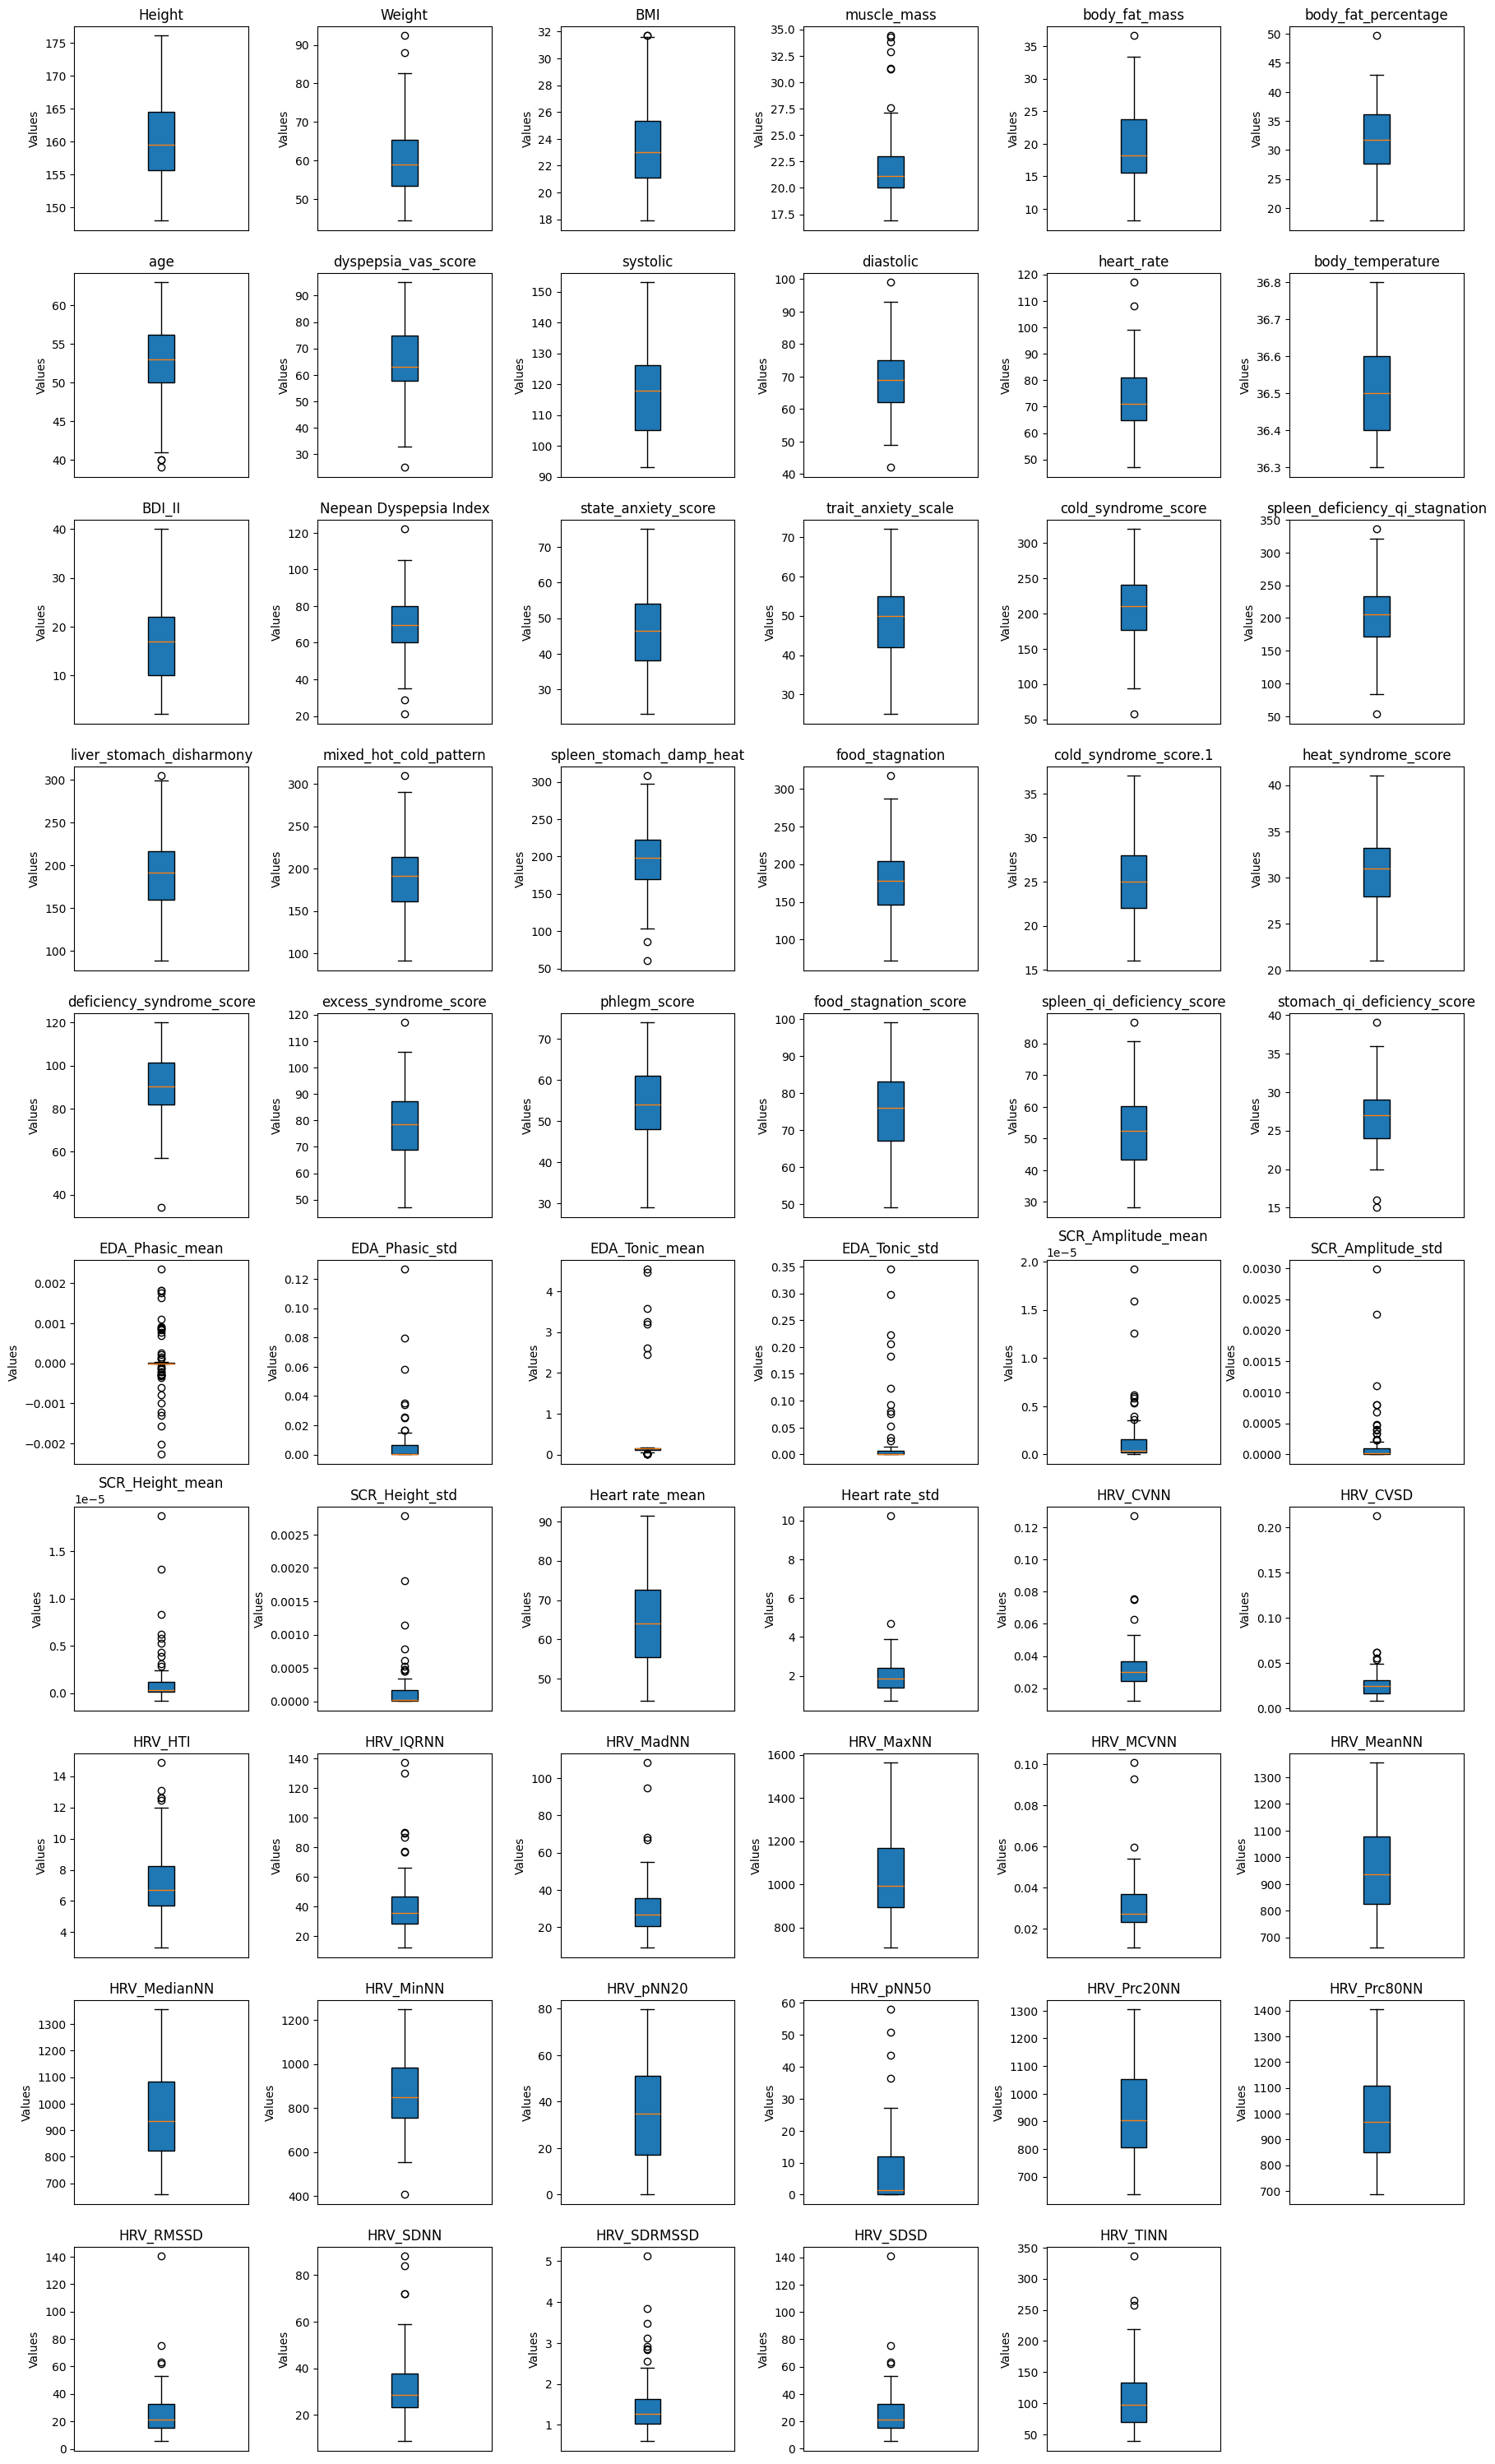

In [5]:
continuous = df.copy()
continuous.drop(columns=['Rome_4_criteria_PDS', 'ed_5q_1', 'ed_5q_2', 'ed_5q_3', 'ed_5q_4', 'ed_5q_5', 'diagnosis', 'diagnosis_type'], inplace=True)
num_vars = len(continuous)
cols = 6
rows = math.ceil(num_vars / cols)

fig, axes = plt.subplots(rows, cols, figsize=(18, rows * 3))
axes = axes.flatten()

# 박스 플롯 그리기
for i, column in enumerate(continuous):
    ax = axes[i]
    if column in df.columns:
        ax.boxplot(df[column].dropna(), vert=True, patch_artist=True)
        ax.set_title(f'{column}')
        ax.set_ylabel('Values')
        ax.set_xticks([])
    else:
        ax.set_visible(False)

# 남은 빈 플롯 제거
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

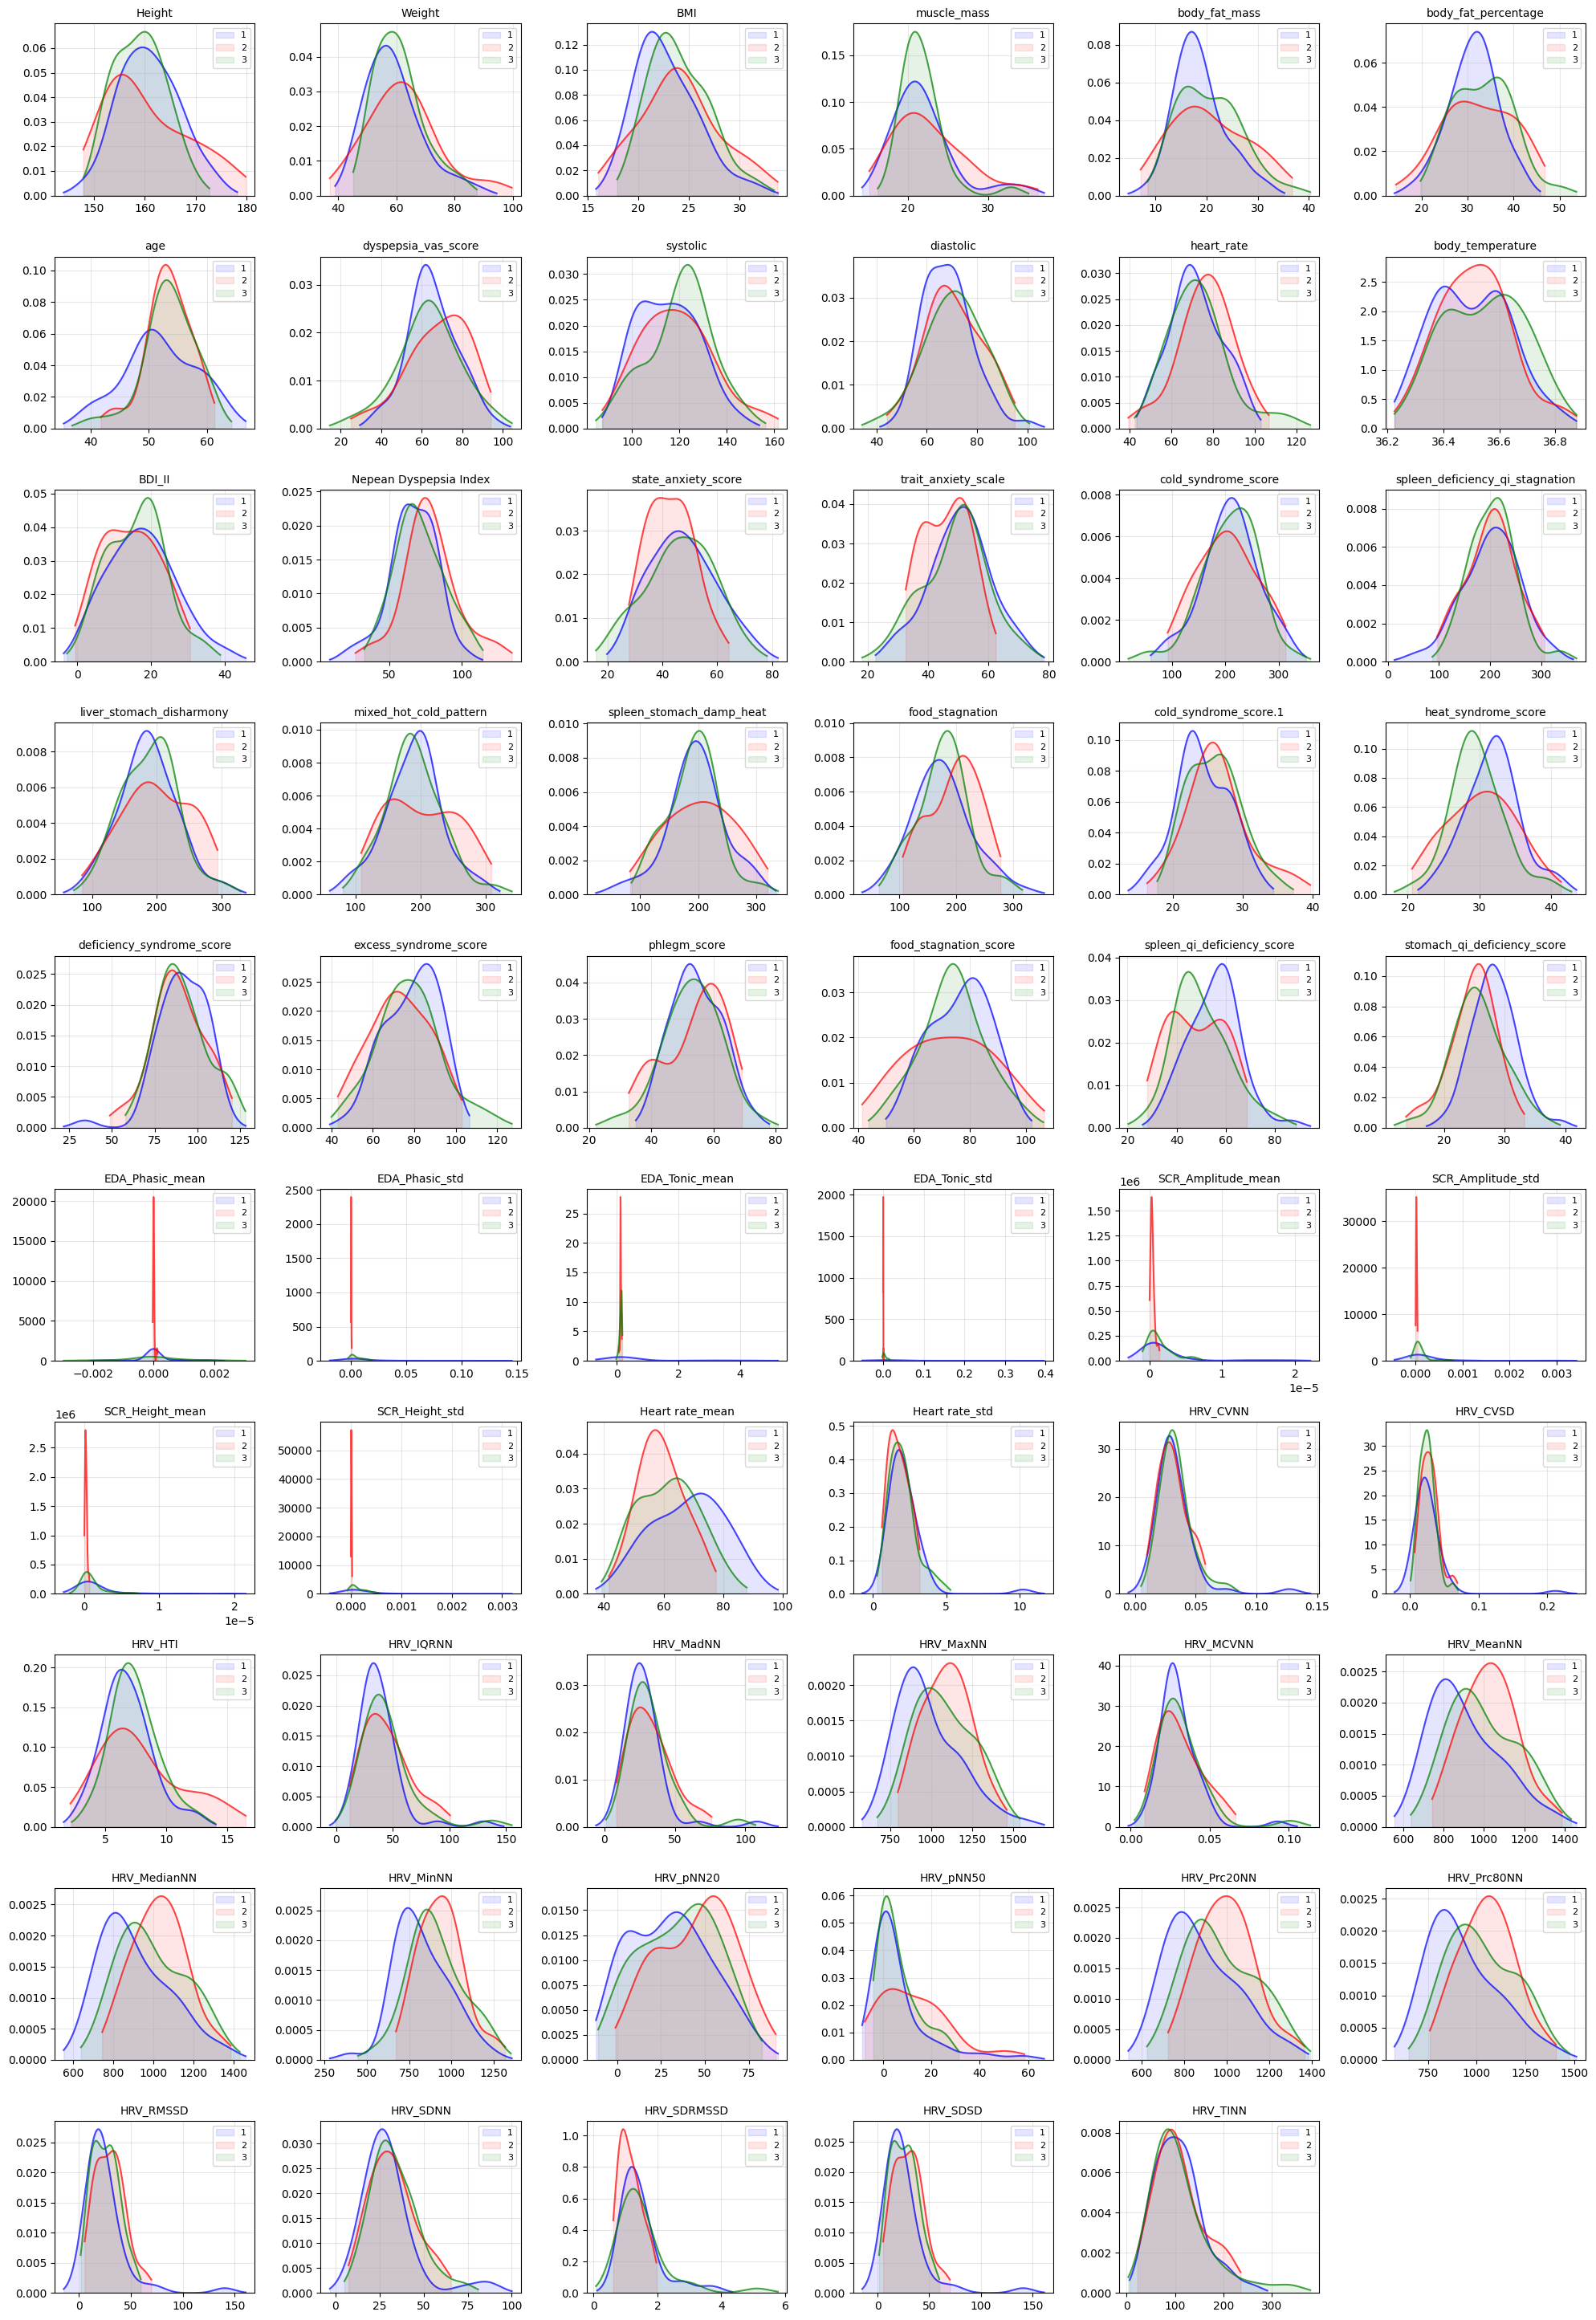

In [6]:
import numpy as np
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt

# diagnosis에 따라 1, 2, 3으로 데이터 나누기
df_1 = df[df['diagnosis_type'] == 1]
df_2 = df[df['diagnosis_type'] == 2]
df_3 = df[df['diagnosis_type'] == 3]

# x축 확장 비율 및 KDE 샘플 개수 설정
x_padding_ratio = 0.15  # x축을 15% 확장
num_points = 500  # KDE x축 샘플 개수 줄이기

num_cols = len(continuous.columns)
fig, axes = plt.subplots(nrows=(num_cols // 6 + 1), ncols=6, figsize=(20, num_cols // 2))
axes = axes.flatten()

for i, column in enumerate(continuous.columns):
    ax = axes[i]

    for df_subset, color, label in zip([df_1, df_2, df_3], ['blue', 'red', 'green'], ['1', '2', '3']):
        variable_data = df_subset[column].dropna()

        # x축 범위 확장 계산
        if len(variable_data) > 0:
            x_min, x_max = variable_data.min(), variable_data.max()
            x_range = x_max - x_min
            x_min -= x_range * x_padding_ratio
            x_max += x_range * x_padding_ratio

            # KDE 적용 가능 여부 확인
            if len(variable_data) >= 5 and variable_data.nunique() > 1:
                kde = gaussian_kde(variable_data)
                x_vals = np.linspace(x_min, x_max, num_points)  # x축 확장 적용
                pdf_vals = kde(x_vals)

                
                # 그래프 채우기 및 선 그리기
                ax.fill_between(x_vals, pdf_vals, color=color, alpha=0.1, label=label)
                ax.plot(x_vals, pdf_vals, color=color, alpha=0.7)
            else:
                # KDE 적용이 불가능한 경우 히스토그램으로 대체
                sns.histplot(variable_data, bins=20, color=color, alpha=0.4, kde=False, label=label, ax=ax)

    ax.set_title(column, fontsize=10)
    ax.legend(fontsize=8)
    ax.grid(alpha=0.3)

    # 🔹 y축 스케일 자동 조정 (너무 큰 값 방지)
    ax.set_ylim(0, None)  

# 남은 axes 비활성화
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [7]:
#scaler = StandardScaler()
#continuous_scaled_array = scaler.fit_transform(continuous)
#continuous_scaled = pd.DataFrame(continuous_scaled_array, columns=continuous.columns)

#df.update(continuous_scaled)


In [8]:
df

,Height,Weight,BMI,muscle_mass,body_fat_mass,body_fat_percentage,age,dyspepsia_vas_score,Rome_4_criteria_PDS,systolic,...,HRV_pNN50,HRV_Prc20NN,HRV_Prc80NN,HRV_RMSSD,HRV_SDNN,HRV_SDRMSSD,HRV_SDSD,HRV_TINN,diagnosis,diagnosis_type
0,150.1,46.7,20.7,16.9,14.6,31.3,58,65,2,112,...,0.0,726.0,764.0,17.464430,23.677708,1.355768,17.517420,117.1875,1,1
1,159.5,49.4,19.4,19.1,13.2,26.7,58,68,2,96,...,0.8,933.8,972.2,20.548330,43.330520,2.108712,20.631677,195.3125,1,1
2,159.3,58.4,23.0,21.1,19.4,33.2,49,61,1,117,...,0.0,740.0,757.0,7.599967,9.792497,1.288492,7.623868,39.0625,1,1
3,160.8,60.0,23.2,21.3,20.9,34.8,53,64,2,103,...,0.0,870.0,907.0,18.781490,20.609342,1.097322,18.846501,93.7500,1,1
4,153.3,57.4,24.4,20.3,19.4,33.9,62,85,2,103,...,0.0,676.0,690.4,5.430592,8.667729,1.596093,5.444862,39.0625,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,158.8,65.2,25.9,21.9,24.9,38.1,55,93,2,118,...,0.0,957.4,980.0,8.560297,13.884949,1.622017,8.588644,54.6875,6,3
96,151.1,60.4,26.5,19.6,23.8,39.4,57,56,1,132,...,0.0,714.4,746.6,10.783504,20.403745,1.892126,10.816764,85.9375,6,3
97,152.6,73.6,31.6,19.8,36.6,49.7,52,82,2,126,...,0.0,856.8,910.0,13.480223,32.323573,2.397851,13.530806,70.3125,6,3
98,150.8,51.4,22.6,18.9,16.2,31.4,56,72,1,115,...,0.0,764.0,809.0,19.915655,26.395615,1.325370,19.977644,117.1875,6,3


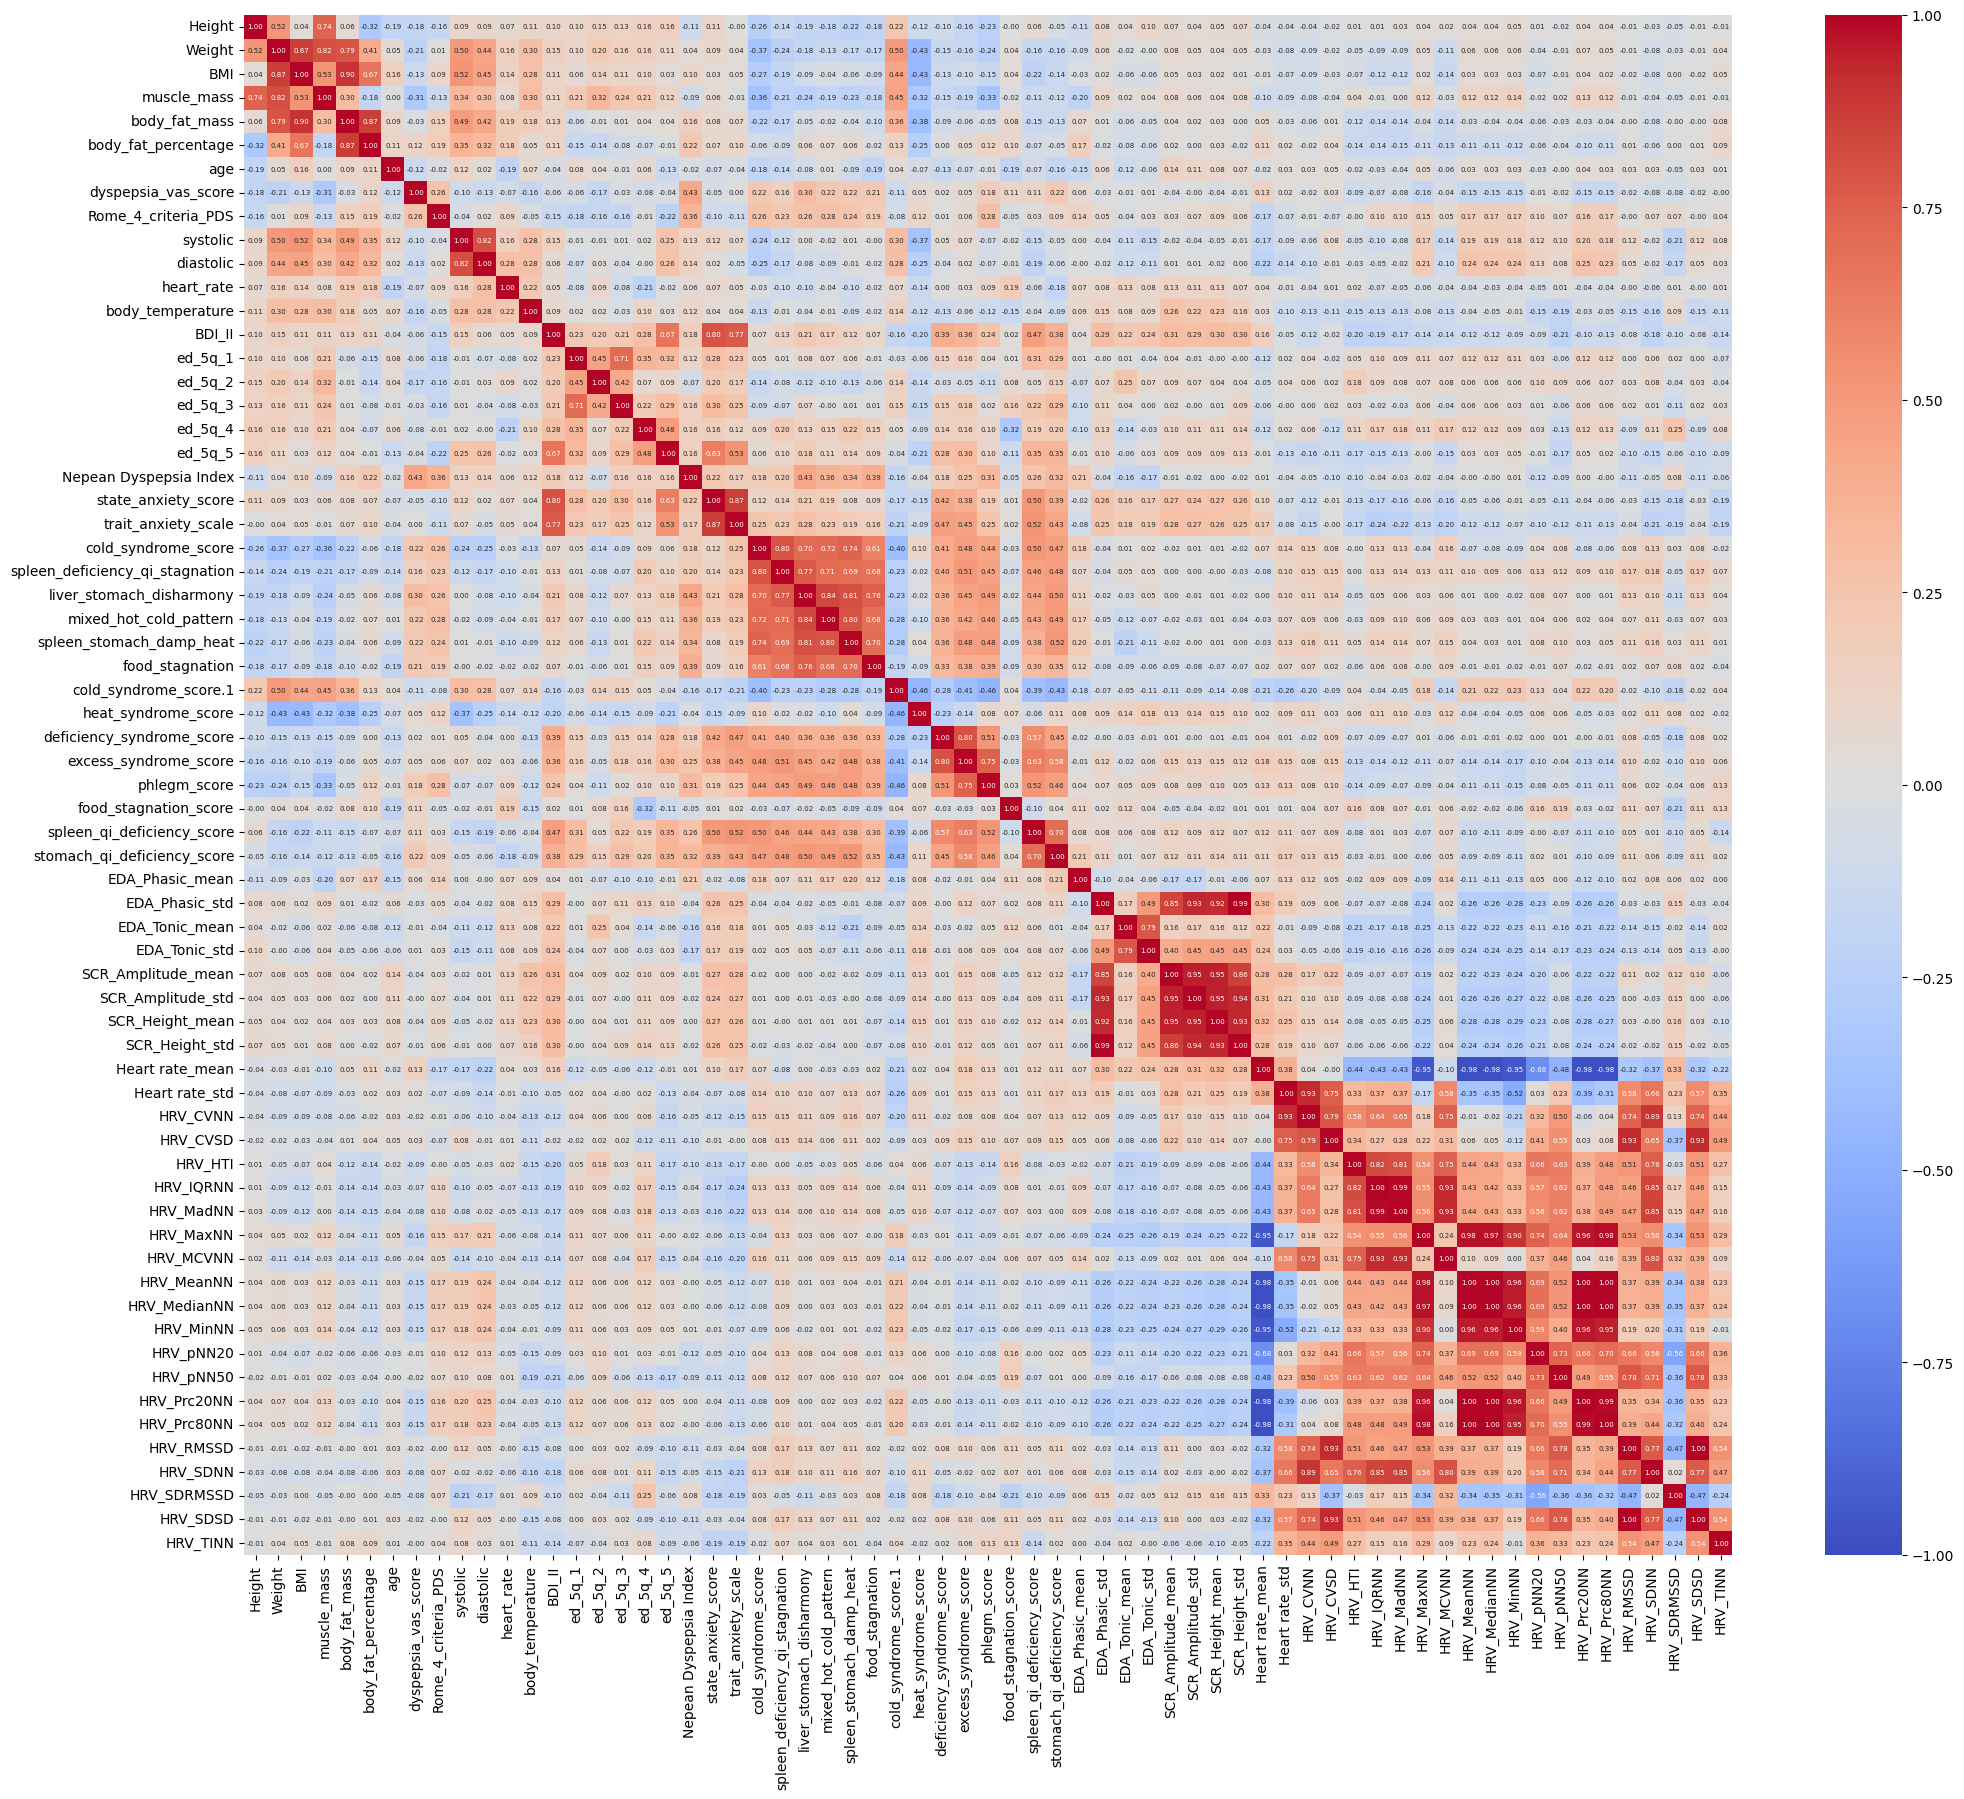

In [9]:
target_1 = df['diagnosis']
target_2 = df['diagnosis_type']
df.drop(columns=['diagnosis', 'diagnosis_type'], inplace=True)

corr = df.corr()
plt.figure(figsize=(24, 20))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 5}, vmin=-1, vmax=1)
plt.show()

In [10]:
t = 0.5

pairs = []
pair_set = set()
for i in range(len(corr.columns)):
    for j in range(i+1, len(corr.columns)):
        if abs(corr.iloc[i, j]) > t:
            col1 = corr.columns[i]
            col2 = corr.columns[j]
            c = corr.iloc[i, j]
            if((col1, col2) not in pair_set): #(col1, col2), (col2, col1) 두번 들어오는 걸 방지
                pairs.append((col1, col2, c))
                pair_set.add((col1, col2))
pairs.sort()
pairs.sort(key=lambda x: x[2], reverse=True)
pairs

[('HRV_RMSSD', 'HRV_SDSD', np.float64(0.9999984243018598)),
 ('HRV_MeanNN', 'HRV_MedianNN', np.float64(0.9996801803494013)),
 ('HRV_MeanNN', 'HRV_Prc80NN', np.float64(0.9981449334533506)),
 ('HRV_MedianNN', 'HRV_Prc20NN', np.float64(0.9980117238684629)),
 ('HRV_MeanNN', 'HRV_Prc20NN', np.float64(0.9975385112192843)),
 ('HRV_MedianNN', 'HRV_Prc80NN', np.float64(0.9972519908114239)),
 ('EDA_Phasic_std', 'SCR_Height_std', np.float64(0.9923830856205644)),
 ('HRV_Prc20NN', 'HRV_Prc80NN', np.float64(0.9918129788585219)),
 ('HRV_IQRNN', 'HRV_MadNN', np.float64(0.9904601465325552)),
 ('HRV_MaxNN', 'HRV_Prc80NN', np.float64(0.9816413268556143)),
 ('HRV_MaxNN', 'HRV_MeanNN', np.float64(0.9752358633527237)),
 ('HRV_MaxNN', 'HRV_MedianNN', np.float64(0.9723855933923325)),
 ('HRV_MinNN', 'HRV_Prc20NN', np.float64(0.9625133568624287)),
 ('HRV_MaxNN', 'HRV_Prc20NN', np.float64(0.9620957116142161)),
 ('HRV_MeanNN', 'HRV_MinNN', np.float64(0.9590908340289095)),
 ('HRV_MedianNN', 'HRV_MinNN', np.float64

In [11]:
df.drop(columns=['EDA_Phasic_std', 'EDA_Tonic_mean', 'EDA_Tonic_std', 'SCR_Amplitude_mean', 'SCR_Amplitude_std', 'SCR_Height_mean', 'SCR_Height_std'], inplace=True)
df.drop(columns=['Heart rate_std', 'HRV_CVNN', 'HRV_CVSD', 'HRV_HTI', 'HRV_IQRNN', 'HRV_MadNN', 'HRV_MaxNN', 'HRV_MCVNN', 'HRV_MeanNN', 'HRV_MedianNN', 'HRV_MinNN', 'HRV_pNN20', 'HRV_pNN50', 'HRV_Prc20NN', 'HRV_Prc80NN', 'HRV_RMSSD', 'HRV_SDNN', 'HRV_SDRMSSD', 'HRV_SDSD', 'HRV_TINN'], inplace=True)
df.drop(columns=['spleen_deficiency_qi_stagnation', 'liver_stomach_disharmony', 'mixed_hot_cold_pattern', 'spleen_stomach_damp_heat', 'food_stagnation'], inplace=True)
df.drop(columns=['body_fat_mass', 'trait_anxiety_scale', 'body_fat_percentage', 'BMI', 'muscle_mass', 'diastolic'], inplace=True)

columns_to_sum = ["ed_5q_1", "ed_5q_2", "ed_5q_3", "ed_5q_4", "ed_5q_5"]
df["ed_5q"] = df[columns_to_sum].sum(axis=1)
df.drop(columns=columns_to_sum, inplace=True)

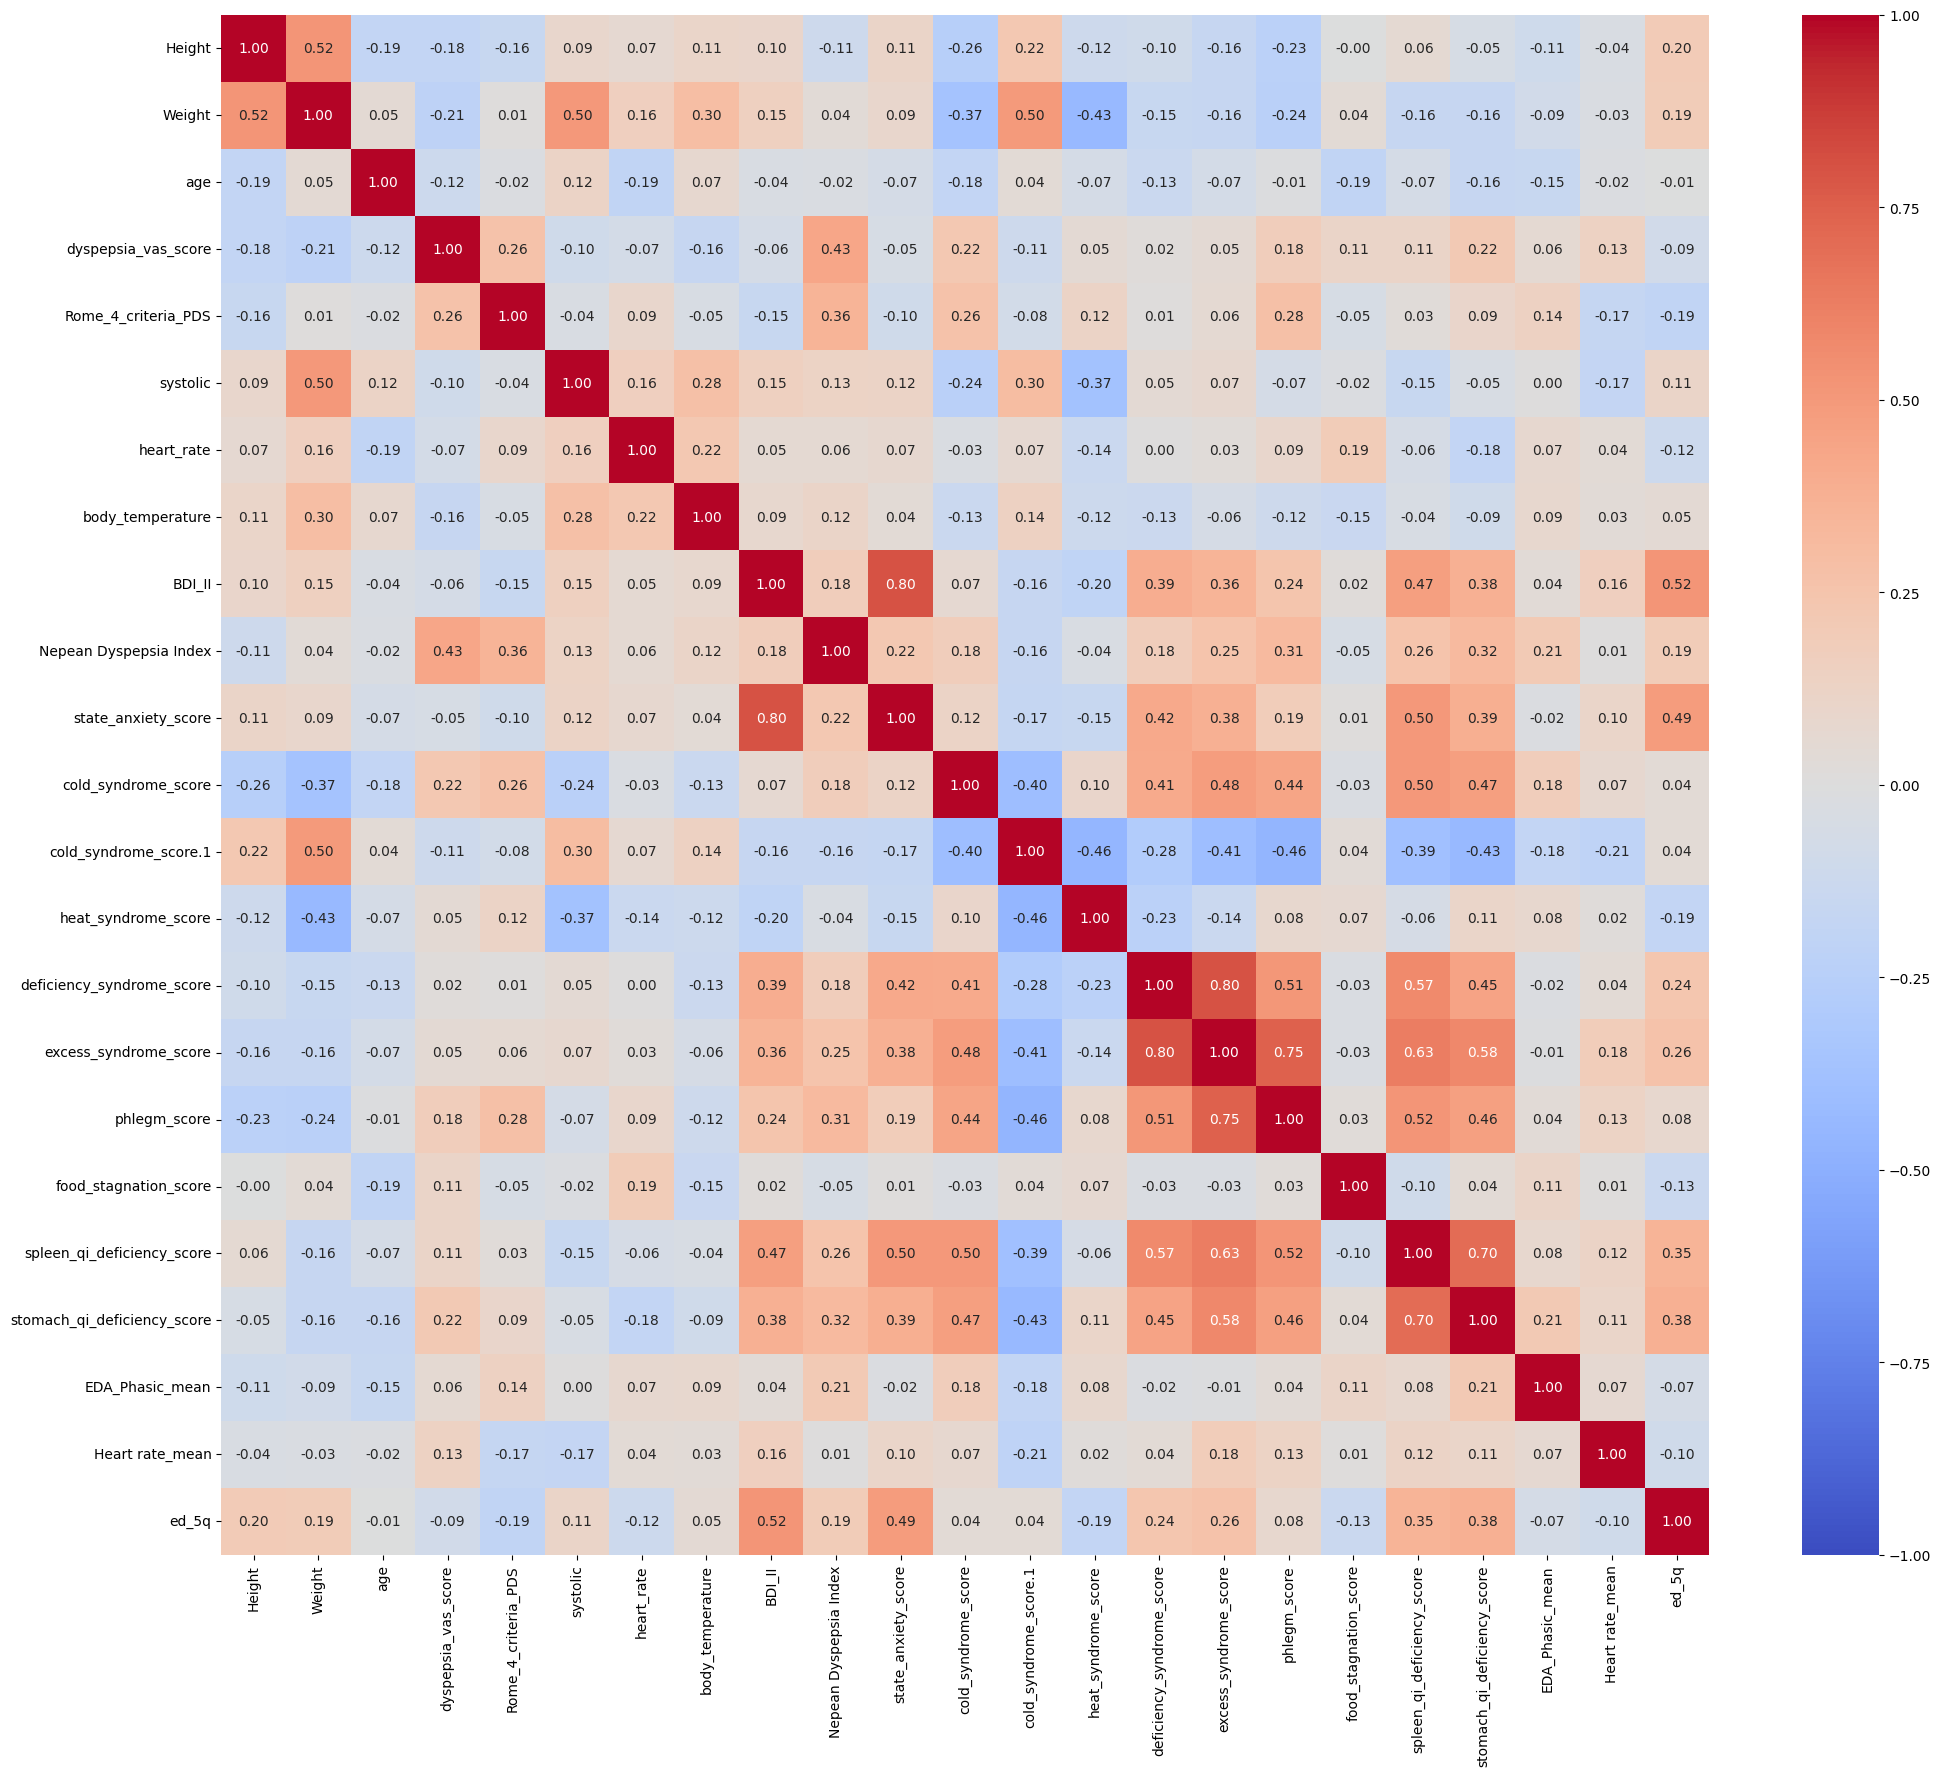

In [12]:
corr = df.corr()
plt.figure(figsize=(24, 20))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 10}, vmin=-1, vmax=1)
plt.show()

In [13]:
t = 0.5

pairs = []
pair_set = set()
for i in range(len(corr.columns)):
    for j in range(i+1, len(corr.columns)):
        if abs(corr.iloc[i, j]) > t:
            col1 = corr.columns[i]
            col2 = corr.columns[j]
            c = corr.iloc[i, j]
            if((col1, col2) not in pair_set): #(col1, col2), (col2, col1) 두번 들어오는 걸 방지
                pairs.append((col1, col2, c))
                pair_set.add((col1, col2))
pairs.sort()
pairs.sort(key=lambda x: x[2], reverse=True)
pairs

[('BDI_II', 'state_anxiety_score', np.float64(0.8041647053150816)),
 ('deficiency_syndrome_score',
  'excess_syndrome_score',
  np.float64(0.7996464666624339)),
 ('excess_syndrome_score', 'phlegm_score', np.float64(0.7465511206649633)),
 ('spleen_qi_deficiency_score',
  'stomach_qi_deficiency_score',
  np.float64(0.695995002280396)),
 ('excess_syndrome_score',
  'spleen_qi_deficiency_score',
  np.float64(0.6288536479601977)),
 ('excess_syndrome_score',
  'stomach_qi_deficiency_score',
  np.float64(0.5826128985208996)),
 ('deficiency_syndrome_score',
  'spleen_qi_deficiency_score',
  np.float64(0.5706669849951236)),
 ('phlegm_score',
  'spleen_qi_deficiency_score',
  np.float64(0.5227256513006296)),
 ('BDI_II', 'ed_5q', np.float64(0.5187458519123425)),
 ('Height', 'Weight', np.float64(0.517472792456088)),
 ('deficiency_syndrome_score', 'phlegm_score', np.float64(0.5149686772086105)),
 ('Weight', 'systolic', np.float64(0.5043845496803475)),
 ('cold_syndrome_score',
  'spleen_qi_deficienc

In [14]:
vif = pd.DataFrame()


vif['VIF_Factor'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
vif['Feature'] = df.columns

vif = vif.sort_values(by='VIF_Factor', ascending=False)
vif

,VIF_Factor,Feature
7,2452.211548,body_temperature
0,1378.348984,Height
15,232.306379,excess_syndrome_score
5,154.321032,systolic
16,145.667839,phlegm_score
14,145.152255,deficiency_syndrome_score
19,142.479532,stomach_qi_deficiency_score
2,133.250130,age
1,122.665353,Weight
13,121.484507,heat_syndrome_score


In [15]:
df['diagnosis'] = target_1
df['diagnosis_type'] = target_2

In [16]:
df

,Height,Weight,age,dyspepsia_vas_score,Rome_4_criteria_PDS,systolic,heart_rate,body_temperature,BDI_II,Nepean Dyspepsia Index,...,excess_syndrome_score,phlegm_score,food_stagnation_score,spleen_qi_deficiency_score,stomach_qi_deficiency_score,EDA_Phasic_mean,Heart rate_mean,ed_5q,diagnosis,diagnosis_type
0,150.1,46.7,58,65,2,112,81,36.5,25,77,...,92.0,65,87,54.44,28,-6.810000e-06,80.581928,5,1,1
1,159.5,49.4,58,68,2,96,70,36.6,4,62,...,47.0,50,83,41.78,27,-1.516730e-04,63.531891,5,1,1
2,159.3,58.4,49,61,1,117,93,36.6,29,63,...,91.0,61,77,64.60,24,-1.038780e-04,80.101085,5,1,1
3,160.8,60.0,53,64,2,103,71,36.4,26,61,...,88.0,62,67,63.27,29,2.613880e-04,67.622235,5,1,1
4,153.3,57.4,62,85,2,103,71,36.8,30,85,...,89.0,65,86,55.94,28,3.310000e-05,87.829793,5,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,158.8,65.2,55,93,2,118,70,36.6,5,105,...,50.0,42,67,41.31,27,-1.050000e-05,61.899495,5,6,3
96,151.1,60.4,57,56,1,132,83,36.7,23,62,...,94.0,62,76,58.04,26,-4.800000e-07,82.248141,7,6,3
97,152.6,73.6,52,82,2,126,58,36.6,21,100,...,88.0,64,51,63.48,29,3.600000e-06,68.184904,7,6,3
98,150.8,51.4,56,72,1,115,70,36.4,13,64,...,90.0,57,84,45.42,25,1.260000e-05,76.306735,5,6,3


In [17]:
df.to_csv('../dataset/dyspepsia_eda.csv')